# <center>Population forecast by country</center>

In [384]:
# The following cells improve formatting of the notebook

In [385]:
# Increase notebook cell width. Cell below increases the height.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [386]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Libraries

In [558]:
import pandas as pd
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import statsmodels
from statsmodels.tsa.stattools import adfuller # for Dickey-Fuller stationarity test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics import tsaplots
from pyramid.arima import auto_arima
from pyramid.arima import ARIMA
import ipywidgets as widgets

In [387]:
matplotlib.rcParams.update({'font.size': 8})

### Objective

Given historical data (1960-2010) for population, fertility rate and life expectancy, try to predict future population **(2011-2016 inclusive)** if the fertility rate and life expectancy for the future periods are known. (???) Or just forecast the population based on historical data only (???)...

...Let's just create the forecast based on the historical data.

### Historical data

In [84]:
%%bash
ls

country_population.csv
df_fr_test.csv
df_fr_train.csv
df_le_test.csv
df_le_train.csv
df_pop_test.csv
df_pop_train.csv
fertility_rate.csv
life_expectancy.csv
world-bank-data-1960-to-2016.zip
world-bank-data-pop_create-train-test-split.ipynb
world-bank-data-pop-model.ipynb


In [85]:
df_pop_train = pd.read_csv("df_pop_train.csv")
df_fr_train = pd.read_csv("df_fr_train.csv")
df_le_train = pd.read_csv("df_le_train.csv")

In [86]:
# Function to transpose, reindex and convert to time series
def preprocess_df(df):
    # Drop unnecessary columns
    df = df.drop(columns=["Unnamed: 0", "Country Code", "Indicator Name", "Indicator Code"])
    # Transpose, so row headings become column headings and vice versa.
    df = df.T
    # Set new column headings
    df.columns = df.iloc[0]
    # Remove redundant row
    df = df.reindex(df.index.drop("Country Name"))
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    return df

In [87]:
# Apply transformation function to each dataset
df_pop_train = preprocess_df(df_pop_train)
df_fr_train = preprocess_df(df_fr_train)
df_le_train = preprocess_df(df_le_train)

In [88]:
# Test slicing on time series
# df_fr_train["1960":"1963"]

### Exploratory analysis

#### Relative change

##### Comparison  - base 100

In [101]:
# make a copy of the df with no values
# loop through the column list and apply a function to create base series for each column name
# after creation of each base series, update the new df created at step 1

In [150]:
# Column headings to loop through when applying base100 function below
cols_df_pop_train = df_pop_train.columns 

In [105]:
# Make copy of original df with no values
df_pop_train_base100 = pd.DataFrame().reindex_like(df_pop_train)

In [135]:
# Function to create base100 series
def create_base100(ts):
    """
    Pass a series from a dataframe.
    Returns the series with base 100.
    """
    return 100 * np.nan_to_num(ts) / ts.iloc[0]

In [138]:
# Populate the base100 dataframe with base series
for col_name in cols_df_pop_train:
    df_pop_train_base100[col_name] = create_base100(df_pop_train[col_name])

In [296]:
# Create widget to be used to highlight a country in below chart
widget_country = widgets.Dropdown(options=list(cols_df_pop_train),
                                        description="Select country:")

In [381]:
# Display country selector widget
widget_country

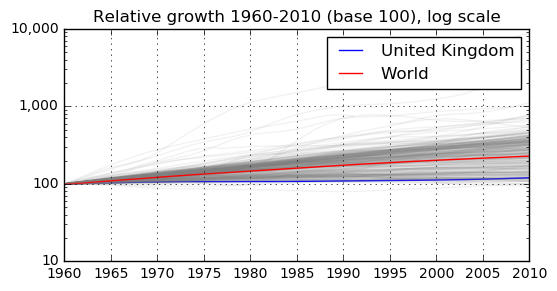

In [602]:
# Plot relative growths, highlighting certain series of interest
fig, ax = plt.subplots(figsize=(6, 3))
for col in cols_df_pop_train:
    if col == widget_country.value:
        color="blue"
        alpha=1
        label=col
    elif col == "World":
        color="red"
        alpha=1
        label="World"
    else:
        color="gray"
        alpha=0.1
        label=""
    ax.plot(df_pop_train_base100[col], alpha=alpha, color=color, label=label)
ax.grid(True)
ax.legend()
plt.yscale("log")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title("Relative growth 1960-2010 (base 100), log scale")

In [389]:
# Top 10 largest relative growth (base 100)
top10_rel_pop_growth = df_pop_train_base100.max().sort_values(ascending=False).head(10).sort_values()

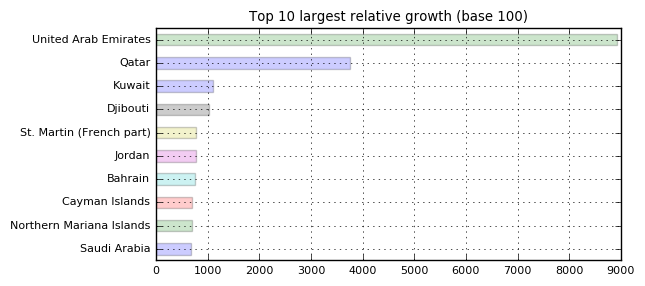

In [390]:
# Plot top 10 largest relative growth (base 100)
fig, ax = plt.subplots(figsize=(6, 3))
ax = top10_rel_pop_growth.plot(kind="barh", alpha=0.2)
ax.grid(True)
ax.set_title("Top 10 largest relative growth (base 100)")
ax.set_ylabel("")

##### Comparison - absolute

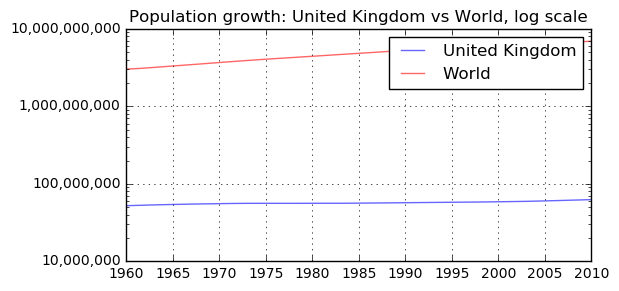

In [603]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_pop_train[widget_country.value], alpha=0.6, color="blue")
ax.plot(df_pop_train["World"], alpha=0.6, color="red")
ax.legend()
ax.grid(True)
ax.set_title("Population growth: %s vs World, log scale" % widget_country.value)
plt.yscale("log")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

#### Create dataframe that exludes the aggregate columns

In [89]:
# The following columns are aggregations, rather than individual countries
# They may well be useful for benchmarking or feature generation,
# but they are skewing the country by country comparison, so we'll exclude
# them for the time being.
aggregate_cols = ["World",
                  "Upper middle income",
                  "Sub-Saharan Africa (IDA & IBRD countries)",
                  "South Asia (IDA & IBRD)",
                  "Middle East & North Africa (IDA & IBRD countries)",
                  "Latin America & the Caribbean (IDA & IBRD countries)",
                  "Europe & Central Asia (IDA & IBRD countries)",
                  "East Asia & Pacific (IDA & IBRD countries)",
                  "Sub-Saharan Africa",
                  "Sub-Saharan Africa (excluding high income)",
                  "South Asia",
                  "Post-demographic dividend",
                  "OECD members",
                  "North America",
                  "Middle East & North Africa (excluding high income)",
                  "Middle income",
                  "Middle East & North Africa",
                  "Late-demographic dividend",
                  "Lower middle income",
                  "Low & middle income",
                  "Latin America & Caribbean",
                  "Least developed countries: UN classification",
                  "Low income",
                  "Latin America & Caribbean (excluding high income)",
                  "IBRD only",
                  "IDA & IBRD total",
                  "IDA total",
                  "IDA blend",
                  "IDA only",
                  "Heavily indebted poor countries (HIPC)",
                  "High income",
                  "Fragile and conflict affected situations",
                  "European Union",
                  "Euro area",
                  "East Asia & Pacific (excluding high income)",
                  "Early-demographic dividend",
                  "East Asia & Pacific",
                  "Europe & Central Asia (excluding high income)",
                  "Europe & Central Asia",
                  "Central Europe and the Baltics",
                  "Arab World"
                  ]

In [90]:
df_pop_train_noagg = df_pop_train.drop(columns=aggregate_cols)

In [91]:
df_pop_train_noagg.head()

Country Name,Aruba,Afghanistan,Angola,Albania,Andorra,United Arab Emirates,Argentina,Armenia,American Samoa,Antigua and Barbuda,...,British Virgin Islands,Virgin Islands (U.S.),Vietnam,Vanuatu,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960-01-01,54211,8.99635e+06,5.64318e+06,1.6088e+06,13411,92634,2.06191e+07,1.87412e+06,20013,55339,...,8033,32500,3.26706e+07,63699,108646,947000,5.17214e+06,1.74569e+07,3.04485e+06,3.74737e+06
1961-01-01,55438,9.16676e+06,5.75302e+06,1.6598e+06,14375,101078,2.09531e+07,1.94149e+06,20486,56144,...,8155,34300,3.36668e+07,65713,112119,966000,5.2605e+06,1.79207e+07,3.14026e+06,3.87076e+06
1962-01-01,56225,9.34587e+06,5.86606e+06,1.71132e+06,15370,112472,2.12877e+07,2.00953e+06,21117,57144,...,8298,35000,3.46842e+07,67808,115788,994000,5.3518e+06,1.84016e+07,3.24059e+06,3.99942e+06
1963-01-01,56695,9.53395e+06,5.98042e+06,1.76262e+06,16412,125566,2.16218e+07,2.07758e+06,21882,58294,...,8452,39800,3.57221e+07,69964,119561,1.022e+06,5.44606e+06,1.88993e+07,3.34514e+06,4.13276e+06
1964-01-01,57032,9.73136e+06,6.09332e+06,1.81414e+06,17469,138529,2.19539e+07,2.145e+06,22698,59524,...,8627,40800,3.6781e+07,72131,123354,1.05e+06,5.54334e+06,1.9413e+07,3.45294e+06,4.26986e+06


### Modeling

#### Helper functions

In [610]:
# Function to plot rolling means and run Dickey-Fuller stationarity test
def test_stationarity(ts):
    
    # Calculate rolling series
#     rolmn = pd.rolling_mean(ts, window=12) - old pandas
    rolmn = ts.rolling(5).mean() # rolling mean - pandas 0.23
#     rolstd = pd.rolling_std(ts, window=12) # rolling standard deviation - old pandas
    rolstd = ts.rolling(5).std() # rolling standard deviation - pandas 0.23
    
    # Plot rolling statistics
    fig, ax = plt.subplots(figsize=(8, 3))
    orig = ax.plot(ts, color="blue", label="Original", alpha=0.6)
    mean = ax.plot(rolmn, color="red", label="Rolling Mean", alpha=0.6)
    std = ax.plot(rolstd, color="black", label="Rolling Std", alpha=0.6)
    ax.legend(loc="best", fontsize=8)
    ax.set_title("Rolling Mean and Standard Deviation")
    ax.set_xlim(min(ts.index))
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.3f}'))
    ax.grid()
    plt.tight_layout()
    plt.show() # Force chart to render before the test results
    
    # Dickey-Fuller stationarity test
    print("Results of Dickey-Fuller test:")
    dftest = adfuller(ts, autolag="AIC")
    df_output = pd.Series(dftest[0:4], index=["Test statistic", "p-value", "#Lags used", "Number of observations used"])
    for key, value in dftest[4].items():
        df_output["Critical value (%s)" % key] = value
    print(df_output)

#### Example model

Let's start by trying to model one time series, the United Kingdom. First, we'll take a manual approach, then we'll use the Pyramid Auto-Arima to see if we can do better.

First, let's test the stationarity of the raw series...

In [611]:
ex_ts = df_pop_train["United Kingdom"].astype(np.int64)

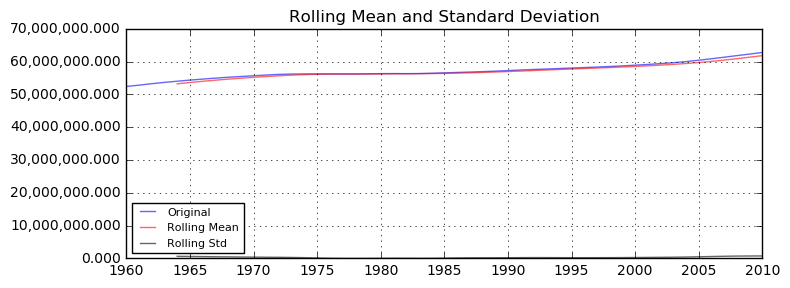

Results of Dickey-Fuller test:
Test statistic                  1.628969
p-value                         0.997942
#Lags used                      6.000000
Number of observations used    44.000000
Critical value (5%)            -2.929886
Critical value (1%)            -3.588573
Critical value (10%)           -2.603185
dtype: float64


In [612]:
test_stationarity(ex_ts)

The test statistic shows us, and we can see visually, that the series is not stationary. There is a clear upward trend and there may even be some seasonality.

Let's transform the series to a log series. When we model all the countries together, converting to log reduce the them all to the same relative scale.

In [613]:
# Log transform
ex_ts_log = np.log(ex_ts)

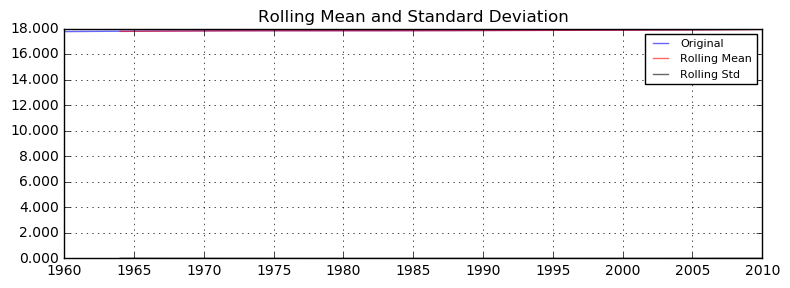

Results of Dickey-Fuller test:
Test statistic                  1.481292
p-value                         0.997454
#Lags used                      6.000000
Number of observations used    44.000000
Critical value (5%)            -2.929886
Critical value (1%)            -3.588573
Critical value (10%)           -2.603185
dtype: float64


In [626]:
test_stationarity(ex_ts_log)

Now, lets apply differencing to eliminate any trend and seasonality effects...

In [614]:
# Differencing
ex_ts_log_diff1 = ex_ts_log - ex_ts_log.shift(1)
ex_ts_log_diff2 = ex_ts_log_diff1 - ex_ts_log_diff1.shift(1)
ex_ts_log_diff3 = ex_ts_log_diff2 - ex_ts_log_diff2.shift(1)
ex_ts_log_diff4 = ex_ts_log_diff3 - ex_ts_log_diff3.shift(1)
ex_ts_log_diff5 = ex_ts_log_diff4 - ex_ts_log_diff4.shift(1)
ex_ts_log_diff5.dropna(inplace=True)

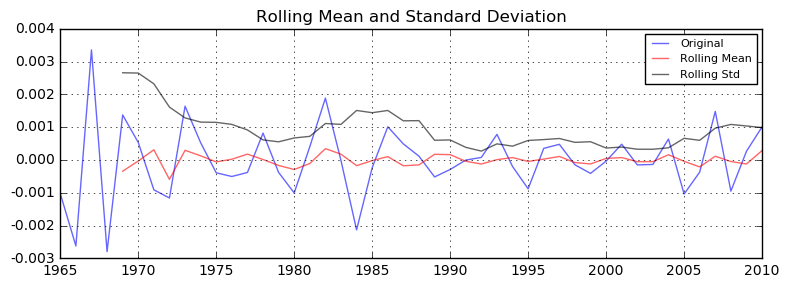

Results of Dickey-Fuller test:
Test statistic                 -4.765863
p-value                         0.000063
#Lags used                      8.000000
Number of observations used    37.000000
Critical value (5%)            -2.943539
Critical value (1%)            -3.620918
Critical value (10%)           -2.610400
dtype: float64


In [615]:
# Test stationarity after log transform and 3rd order differencing
test_stationarity(ex_ts_log_diff5)

The question now is: is ex_ts_log_diff3 pure white noise, or is there and remaining signal that needs to be removed? We'll attempt to answer that question using the ACF.

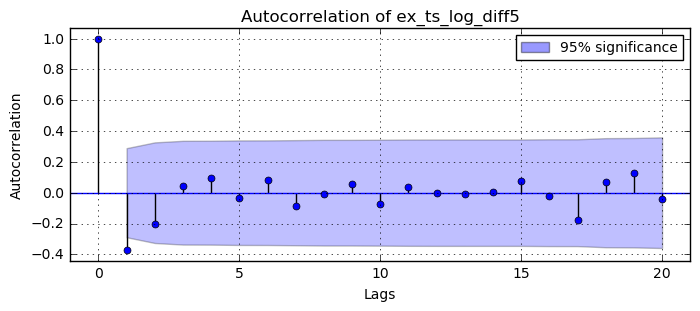

In [616]:
legend_elements = [Patch(facecolor="blue", alpha=0.4, label="95% significance")]

fig, ax = plt.subplots(figsize=(8, 3))
ax = tsaplots.plot_acf(ex_ts_log_diff5, lags=20, ax=ax, alpha=.05, title="Autocorrelation of ex_ts_log_diff5")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend(handles=legend_elements, fontsize=10)
plt.show()

In the ACF plot above, values outside the blue 95% significance band are indication of non-random autocorrelations, which means there is still signal (juice, to keep the sugar can analogy going) in the data to be extracted by the AR and MA models.

There is also clear evidence of seasonality left in the data at lag 12, which makes sense as we can observe the annual (12-month) seasonality in the original series. As a reminder, the seasonality component we extracted earlier is reproduced below.

**The first lag value that is outside the significance band can be used as the q value for the ARIMA model.**

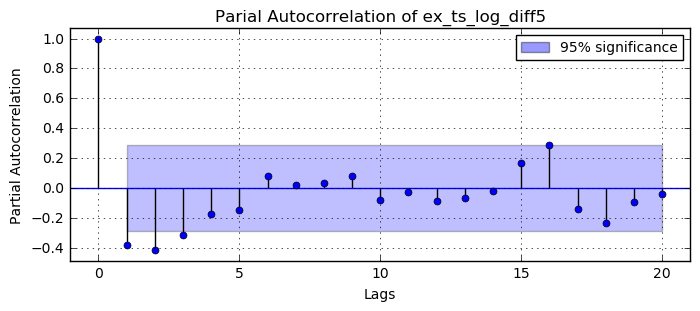

In [617]:
legend_elements = [Patch(facecolor="blue", alpha=0.4, label="95% significance")]

fig, ax = plt.subplots(figsize=(8, 3))
ax = tsaplots.plot_pacf(ex_ts_log_diff5, lags=20, ax=ax, alpha=.05, title="Parial Autocorrelation of ex_ts_log_diff5")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.grid(True)
plt.legend(handles=legend_elements, fontsize=10)
plt.show()

The PACF also helps us identify remaining non-stationarity in the series. It also is calculated as the correlation of a series with its lagged values, but this time, after removing the effects of intermediate periods. For example, for a lag value of 5, we calculate the correlation between t and t-5, but after eliminating the effect of periods t-1...t-4.

**This helps us identify the value for p in the ARIMA model.**

In [618]:
model = statsmodels.tsa.arima_model.ARIMA(ex_ts_log_diff5, order=(3, 0, 1))
results_ARIMA = model.fit(disp=-1) # disp<0 suppresses verbose output
RSS_ARIMA = sum((results_ARIMA.fittedvalues-ex_ts_log_diff5)**2)
RMSE_ARIMA = np.sqrt(sum((results_ARIMA.fittedvalues-ex_ts_log_diff5)**2)/len(ex_ts_log_diff5))

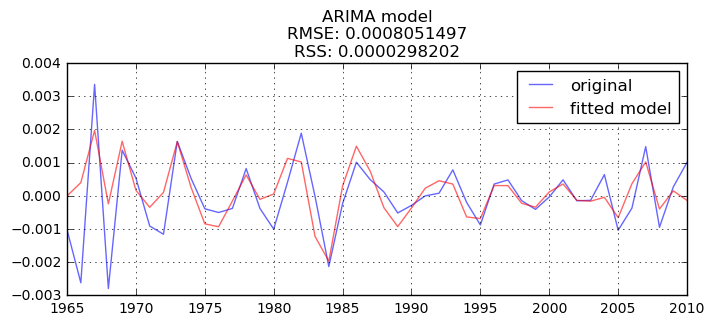

In [625]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ex_ts_log_diff5, alpha=0.6, label="original")
ax.plot(results_ARIMA.fittedvalues, color="red", alpha=0.6, label="fitted model")
ax.set_title("ARIMA model\nRMSE: %.10f\nRSS: %.10f" % (RMSE_ARIMA, RSS_ARIMA))
ax.grid()
ax.legend()

Now we need to convert the fitted values back to the original scale...

In [623]:
# First we make a copy of the fitted values and store in a Pandas Series
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA.head()

1965-01-01   -0.000003
1966-01-01    0.000397
1967-01-01    0.001967
1968-01-01   -0.000242
1969-01-01    0.001643
dtype: float64

In [ ]:
# The predictions are differences

#### Auto arima

In [590]:
widget_country

In [591]:
ts = df_pop_train[widget_country.value]

In [592]:
stepwise_fit = auto_arima(ts, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1047.387, BIC=1050.662, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1652.063, BIC=1658.614, Fit time=0.553 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1049.215, BIC=1054.128, Fit time=0.148 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1653.900, BIC=1658.813, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1252.035, BIC=1258.585, Fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   51
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -521.693
Date:                            Sat, 28 Jul 2018   AIC                           1047.387
Time:                                    02:01:47   BIC                           1050.662
Sample:                                         0   HQIC                          1048.552
                                             - 51                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.561e+04   4.11e+04      0.380      0.704   -6.49e+04    9.61e+04
sigma2      4.922e+10   1.74e+10      2.834      0.005    1.52e+10    8.33e+10
===================================================================================
Ljung-Box (Q):                      370.61   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               0.51   Skew:                            -0.51
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [593]:
stepwise_fit.aic()

1047.386652468828

#### Fit a model using hyperparameters from auto arima

In [599]:
# Fit an ARIMA model with the optimal hyperparameters discovered by auto arima above.
fit = ARIMA(order=(0, 1, 0), seasonal_order=(0, 1, 0, 12)).fit(y=ts)

#### Evaluate the fit

In [600]:
def evaluate_fit(ts, fit):
    fit_data = fit.predict_in_sample()
    ts.plot(label="actual")
    RMSE_ARIMA = np.sqrt((sum((ts-fit_data)**2))/len(ts))
    plt.plot(fit_data, label="predicted")
    plt.legend()
    plt.title("RMSE: %.2F" % RMSE_ARIMA)

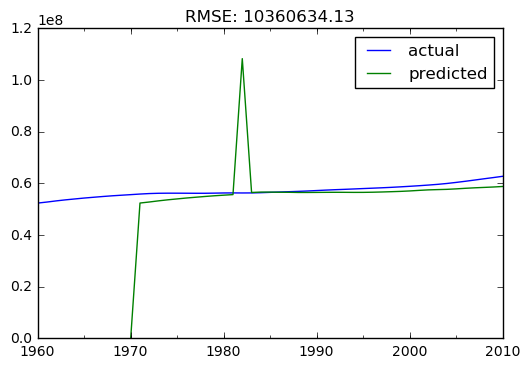

In [601]:
evaluate_fit(ts, fit)